# Video Game Sales Data Analysis

This data analysis of video game sales data between regions provide insight on how a video game will sell in each region. We will look at how user ratings, critic ratings, and ESRB ratings affect sales. We will also look at games sales based on their genre, platform, and region.

+ Purpose: Identify patterns that determine whether a game succeeds or not.

+ Plan: Analyze data between 2012 and 2016 which includes the end of one platform generation's life and the transition to a new platform generation and make a prediction for 2017.

## Initialization

In [1]:
# Load the Libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

## Load Data

In [2]:
# Read the data from the csv file
try:
    games = pd.read_csv('./datasets/moved_games.csv')
except:
    games = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/moved_games.csv')


## Prepare the Data

In [3]:
# Change the column names to lowercase
games.columns = games.columns.str.lower()
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


#### Check for duplicates

In [4]:
print(games.duplicated().sum())

# Check for records that have the same name, platform, and release year information
duplicates = games.duplicated(subset=['name', 'platform', 'year_of_release'], keep=False)
display(games[duplicates])

0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E


Since there is one game that has a duplicate, we can add the sales columns together so everything is counted and not lost. The other duplicate will be dropped later.

In [5]:
# First, we group by the columns that define uniqueness
grouped = games.groupby(['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating'])

# Then, we sum the sales columns within each group
df_merged = grouped[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum().reset_index()

# Find out what happened to that one duplicate.
display(df_merged[(df_merged['name'] == 'Madden NFL 13') & (df_merged['platform'] == 'PS3')])

,name,platform,year_of_release,genre,critic_score,user_score,rating,na_sales,eu_sales,jp_sales,other_sales
3600,Madden NFL 13,PS3,2012.0,Sports,83.0,5.5,E,2.11,0.23,0.0,0.23


The duplicated game is now merged, adding the eu_sales since it's the only column that has information on the duplicate, and keeping everything else the same.

In [6]:
# Create lists of unique values from columns
platforms = games['platform'].unique()
genres = games['genre'].unique()
ratings = games['rating'].unique()
user_scores = games['user_score'].unique()
critic_scores = games['critic_score'].unique()

#### Handle missing values

In [7]:
# Handle 'tbd' in the user_score column (change them to NaN)
games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce')

In [8]:
# Fill in missing values in the 'critic_score' column with 0
games['critic_score'] = games['critic_score'].fillna(0)

# Fill in missing values for the rating column with 'Not Rated'
games['rating'] = games['rating'].fillna('Not Rated')

# Drop records with missing values in the name and genre columns
games = games.dropna(subset=['name', 'genre'])

# Fill missing values before converting.
games['year_of_release'] = games['year_of_release'].fillna(0)

C:\Users\cosmi\AppData\Local\Temp\ipykernel_10836\331214196.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games['year_of_release'] = games['year_of_release'].fillna(0)


For rating, I filled in missing values with "Not Rated". For numeric values, I decided to fill missing values for the ones I wanted to convert to int with 0. Since there is no 0 rating from the critic_score column and no record has year_of_release of 0, I can just exclude 0s from future calculations if necessary. I also converted 'tbd' values from 'user_score' to NaN with pd.to_numeric(). This made the 'user_score' column a float instead of an object for calculations.

It's possible that some games were just not rated by the users or critics. Games do not have to be rated by the ESRB, but in order for stores to sell them or console manufacturers to allow games for their consoles, they have to be rated by the ESRB. Therefore, not all games have ratings. Year of release may also be unknown.

#### Handle erroneous data

In [9]:
# Filter erroneous data
filtered_rows = games[(games['platform'] == 'DS') & (games['year_of_release'] > 0) & (games['year_of_release'] < 2004)]

# Display the filtered rows
display(filtered_rows)

# Count the number of rows
initial_row_count = len(games)

# Drop that game from the dataframe since the release date entered is before the
# platform was released.
games = games[~((games['platform'] == 'DS') & (games['year_of_release'] > 0) & (games['year_of_release'] < 2004))]

# Subtract the number of rows remaining
deleted_row_count = initial_row_count - len(games)

# Print number of deleted rows
print(deleted_row_count)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
15957,Strongest Tokyo University Shogi DS,DS,1985.0,Action,0.0,0.0,0.02,0.0,0.0,NaN,Not Rated


1


#### Convert column types where necessary

In [10]:
# Release year does not make sense to have decimal points as years don't have decimals, 
# so it has to be converted from float to int.
# Convert the 'year_of_release' column from float to int. 
if np.array_equal(games['year_of_release'], games['year_of_release'].astype('int')):
    games['year_of_release'] = games['year_of_release'].astype(int)

# Critic score seems to be integers between 1 and 100.
# Convert the 'critic_score' column from float to int.
if np.array_equal(games['critic_score'], games['critic_score'].astype('int')):
    games['critic_score'] = games['critic_score'].astype(int)

games.info()
display(games.sample(5))

<class 'pandas.core.frame.DataFrame'>
Index: 16712 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16712 non-null  object 
 1   platform         16712 non-null  object 
 2   year_of_release  16712 non-null  int32  
 3   genre            16712 non-null  object 
 4   na_sales         16712 non-null  float64
 5   eu_sales         16712 non-null  float64
 6   jp_sales         16712 non-null  float64
 7   other_sales      16712 non-null  float64
 8   critic_score     16712 non-null  int32  
 9   user_score       7590 non-null   float64
 10  rating           16712 non-null  object 
dtypes: float64(5), int32(2), object(4)
memory usage: 1.4+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1584,Star Wars: The Force Unleashed,PS2,2008,Action,0.49,0.00,0.01,0.75,68,7.4,T
9733,Summon Night 3,PSP,2012,Role-Playing,0.00,0.00,0.12,0.00,0,NaN,Not Rated
13961,Wicked Monster Blast!,Wii,2011,Shooter,0.03,0.00,0.00,0.00,0,NaN,Not Rated
8190,Back to the Future: The Game,PS4,2015,Adventure,0.10,0.05,0.00,0.03,0,7.1,T
14265,Dream C Club Zero,X360,2011,Simulation,0.00,0.00,0.03,0.00,0,NaN,Not Rated


#### Calculate the total sales for each game and put them in a separate column

In [11]:
# Calculate the total sales for each game
games['total_sales'] = games[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)

So far, the data for analysis by handling the duplicates and filling in missing values where appropriate while leaving some where it could significanltly alter the analysis of the data. We will now analyze the sales data. Do user and critic scores affect total sales? Which genres have the highest sales? How do different platforms perform when it comes to game sales?

## Data Analysis

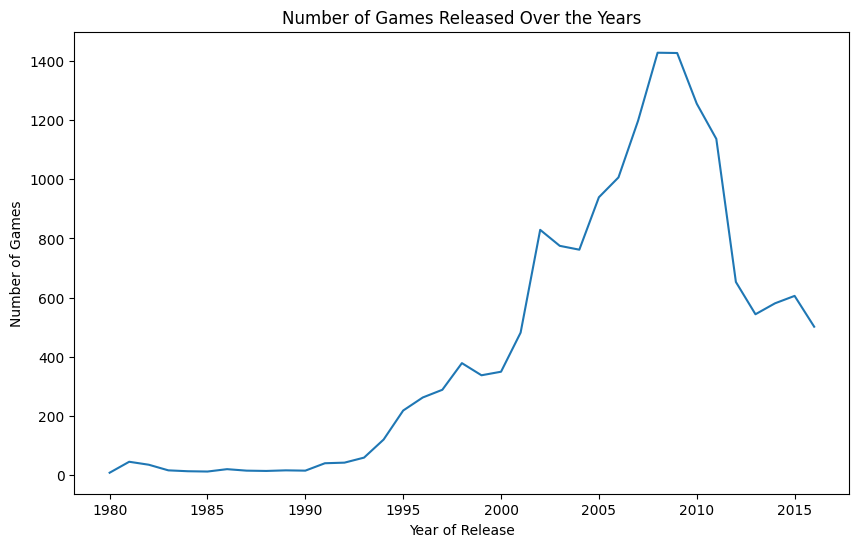

In [12]:
# Count the number of games released in different years
games = games[games['year_of_release'] != 0]
games_per_year = games['year_of_release'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.plot(games_per_year.index, games_per_year.values)

# Add title and labels
plt.title('Number of Games Released Over the Years')
plt.xlabel('Year of Release')
plt.ylabel('Number of Games')

# Show the plot
plt.show()

Based on this chart, we can see the release of games have almost an exponential increase year after year until about 2009. The number of games released then significantly dropped.

platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.76
PS       727.58
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
PC       255.76
GB       254.43
XB       251.57
NES      251.05
N64      218.01
SNES     200.04
GC       196.73
XOne     159.32
2600      86.48
WiiU      82.19
PSV       53.81
SAT       33.59
GEN       28.35
DC        15.95
SCD        1.86
NG         1.44
WS         1.42
TG16       0.16
3DO        0.10
GG         0.04
PCFX       0.03
Name: total_sales, dtype: float64


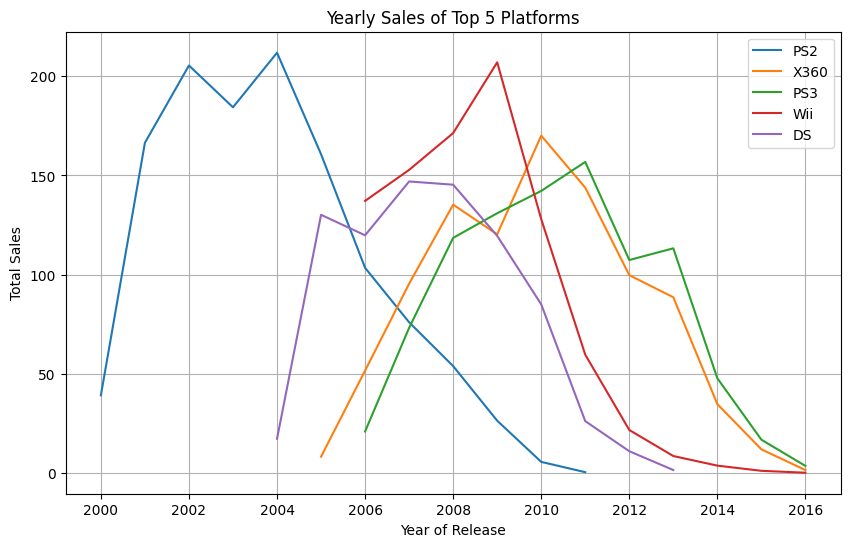

In [13]:
# Group the data by platform and sum the sales
platform_sales = games.groupby('platform')[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum()

# Calculate total sales for each platform
platform_sales['total_sales'] = platform_sales.sum(axis=1)

# Display the platforms with the greatest total sales
top_platforms = platform_sales['total_sales'].sort_values(ascending=False)
print(top_platforms)

# Get the top 5 platforms
top_5_platforms = top_platforms.index[:5]

# Filter the data for the top 5 platforms
top_platforms_data = games[games['platform'].isin(top_5_platforms)]

# Group by year and platform and sum the sales
yearly_sales = top_platforms_data.groupby(['year_of_release', 'platform'])[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum()

# Calculate total sales for each year
yearly_sales['total_sales'] = yearly_sales.sum(axis=1)

# Reset the index for plotting
yearly_sales_reset = yearly_sales.reset_index()

# Plot the distribution of sales for each year for the top 5 platforms
plt.figure(figsize=(10, 6))
for platform in top_5_platforms:
    platform_data = games[games['platform'] == platform]
    yearly_sales = platform_data.groupby('year_of_release')['total_sales'].sum()
    plt.plot(yearly_sales.index, yearly_sales.values, label=platform)

plt.title('Yearly Sales of Top 5 Platforms')
plt.xlabel('Year of Release')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()

It can be said that the top 5 platforms when it comes to sales were from the period between 2005 and 2015. They all peaked around 2010 and then declined. All the games for these consoles have nearly 0 in sales in the last year of the data. Looking at the chart, it appears they are generally around for about 10 years.

In [14]:
# Find the year of the first and last game released for each platform
platform_lifespan = games.groupby('platform')['year_of_release'].agg(['min', 'max'])

# Calculate the lifespan of each platform
platform_lifespan['lifespan'] = platform_lifespan['max'] - platform_lifespan['min']

# Sort by min which may indicate release year of the platform
sorted_df = platform_lifespan.sort_values(by='min')

print(sorted_df)

           min   max  lifespan
platform                      
2600      1980  1989         9
NES       1983  1994        11
PC        1985  2016        31
GB        1988  2001        13
SNES      1990  1999         9
GEN       1990  1994         4
GG        1992  1992         0
SCD       1993  1994         1
NG        1993  1996         3
SAT       1994  1999         5
PS        1994  2003         9
3DO       1994  1995         1
TG16      1995  1995         0
PCFX      1996  1996         0
N64       1996  2002         6
DC        1998  2008        10
WS        1999  2001         2
GBA       2000  2007         7
XB        2000  2008         8
PS2       2000  2011        11
GC        2001  2007         6
DS        2004  2013         9
PSP       2004  2015        11
X360      2005  2016        11
PS3       2006  2016        10
Wii       2006  2016        10
PSV       2011  2016         5
3DS       2011  2016         5
WiiU      2012  2016         4
PS4       2013  2016         3
XOne    

In [15]:
# Create a dataframe that only includes games released between 2012 and 2016
games_filtered = games[(games['year_of_release'] >= 2012) & (games['year_of_release'] <= 2016)]

In the '80s a new platform was introduced every couple or few years, while in the '90s, new platforms were introduced just about every year. In the 2000s, the consoles were released about the same years, roughly 5-6 years apart. The handhelds (DS and PSP) were released mid generations of the consoles. It looks like a platform generally lasts between 5 to 10 years. As a new generation of platforms emerge, the older one slowly fades away for another several years. 

Let's look at the data from 2012 to the last year of the data that we have, which is 2016. These are the consoles that are the latest generation at the time. I chose this time period for the next part of the analysis because it captures data from when the previous generation of platforms were still strong and the release of the new generation of platforms and how the sales transition was between them.

          total_sales  game_counts
platform                          
PS4            314.14          392
PS3            288.79          493
X360           236.54          292
3DS            194.61          396
XOne           159.32          247
WiiU            82.19          147
PC              62.65          250
PSV             49.18          411
Wii             35.37           54
DS              12.55           31
PSP             11.19          173


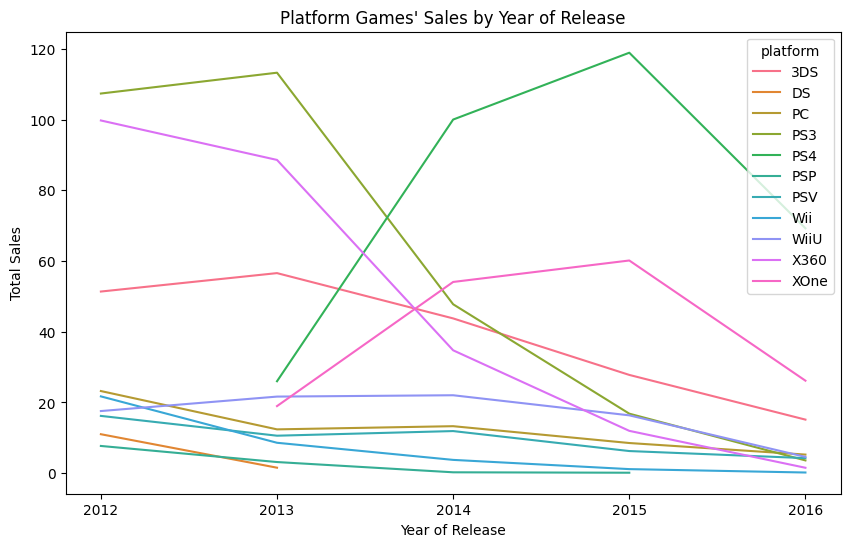

In [16]:
# Group the data by platform and sum the total sales
platform_sales = games_filtered.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

# Add number of games
platform_sales_df = pd.DataFrame(platform_sales)
platform_game_counts = games_filtered.groupby('platform')['name'].count()
platform_sales_df['game_counts'] = platform_game_counts

# Display the platforms leading in sales
print(platform_sales_df)

# Group the data by platform and year_of_release, and sum the total_sales
platform_yearly_sales = games_filtered.groupby(['platform', 'year_of_release'])['total_sales'].sum().reset_index()



# Create a line plot of total sales by year_of_release for each platform
plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=platform_yearly_sales, x='year_of_release', y='total_sales', hue='platform')

plt.title('Platform Games\' Sales by Year of Release')
plt.xlabel('Year of Release')
plt.ylabel('Total Sales')
ax.xaxis.set_ticks(np.arange(2012, 2017, 1))
plt.show()


PS4, PS3, Xbox 360, and 3DS were leading in number of games released at this period. The previous generation (which includes PS3, Xbox 360, and Wii) were shrinking, while the current generation at the time (PS4 and Xbox One) went up 2014 and 2015, but was lower in 2016. The 3DS dominated the handheld market.

In [17]:
# Reviewer's code

games_filtered.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012,51.36,11.01,23.22,107.36,NaN,7.69,16.19,21.71,17.56,99.74,NaN
2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,NaN,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,NaN,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,NaN,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


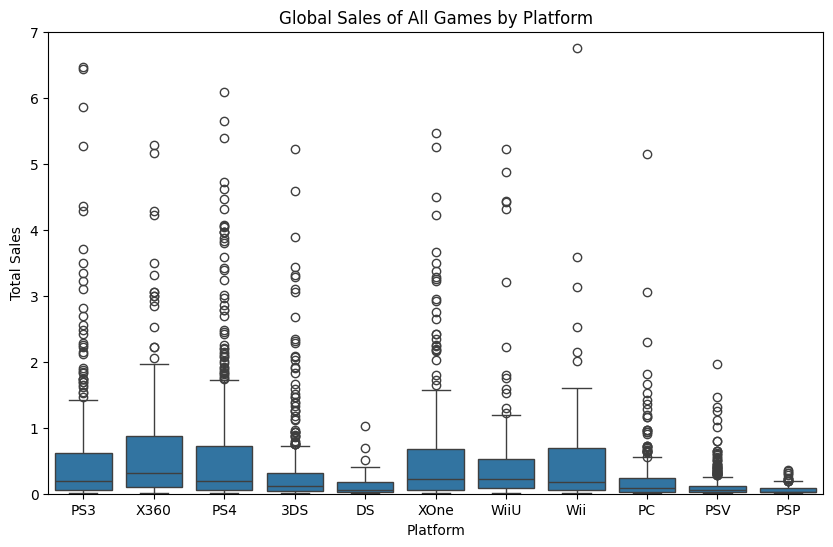

In [18]:
# Create a box plot of global sales by platform
plt.figure(figsize=(10, 6))
sns.boxplot(x='platform', y='total_sales', data=games_filtered)
plt.ylim([0, 7])
plt.title('Global Sales of All Games by Platform')
plt.xlabel('Platform')
plt.ylabel('Total Sales')
plt.show()

Between 2012 and 2016, the previous generation of platforms are still pretty popular and their game releases are still strong, while the transition to the new generation took place on 2014. The average sales seem to be the same between new and old platforms. There are a lot of outliers, which could be games that did exceptionally well in sales compared to the rest.



In [19]:
# Filter out games that have no critic score
games_critics = games_filtered[games_filtered['critic_score'] != 0]

Games that have no critic scores were removed from the analysis from this point.

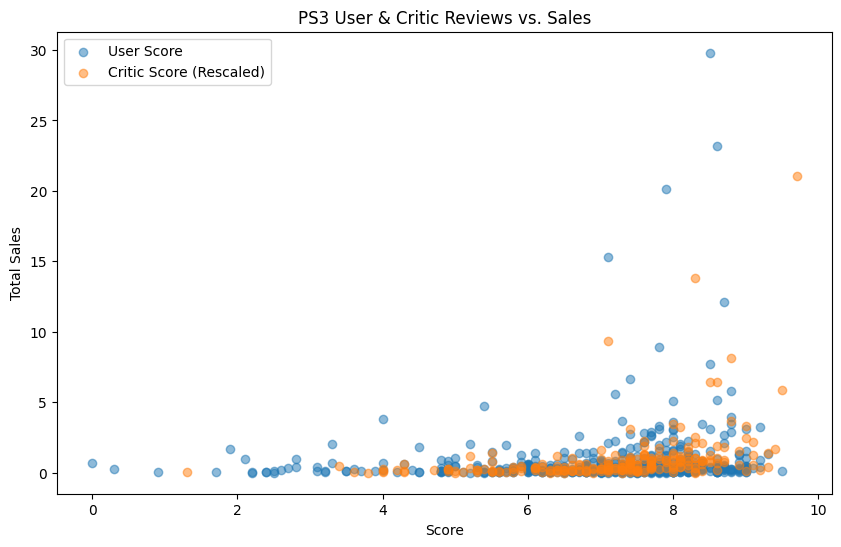

                       critic_score_rescaled  user_score  total_sales
critic_score_rescaled               1.000000    0.539456     0.331497
user_score                          0.539456    1.000000    -0.005144
total_sales                         0.331497   -0.005144     1.000000


In [20]:
# Specify PS3 as the platform
platform_users = games_filtered[games_filtered['platform'] == 'PS3'].copy()
platform_critics = games_critics[games_critics['platform'] == 'PS3'].copy()

# Rescale critic scores so they can be comparable to user scores
platform_critics['critic_score_rescaled'] = platform_critics['critic_score'] / 10

plt.figure(figsize=(10, 6))

# Scatter plot for user_score
plt.scatter(platform_data['user_score'], platform_data['total_sales'], alpha=0.5, label='User Score')

# Scatter plot for rescaled critic_score
plt.scatter(platform_critics['critic_score_rescaled'], platform_critics['total_sales'], alpha=0.5, label='Critic Score (Rescaled)')

plt.title('PS3 User & Critic Reviews vs. Sales')
plt.xlabel('Score')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

# Calculate the correlation between rescaled critic scores, user scores, and total sales
# Add 'critic_score_rescaled' to 'platform_users'
platform_users['critic_score_rescaled'] = platform_critics['critic_score_rescaled']

# # Calculate the correlation
correlation = platform_users[['critic_score_rescaled', 'user_score', 'total_sales']].corr()

print(correlation)

Critic scores are rescaled so that they are visually comparable to user scores.

It looks like there is no significant correlation between either score and the total sales for a game on the Playstation 3 console. 

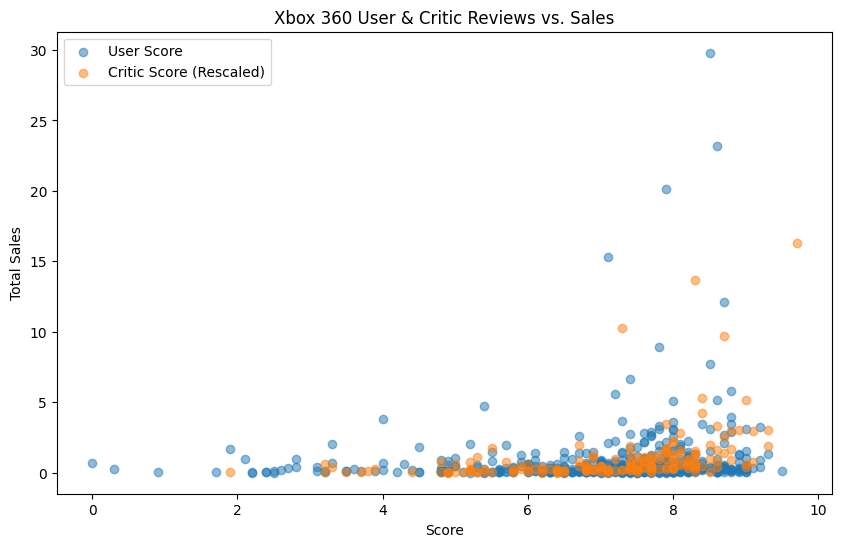

                       critic_score_rescaled  user_score  total_sales
critic_score_rescaled               1.000000    0.557352     0.360573
user_score                          0.557352    1.000000     0.006164
total_sales                         0.360573    0.006164     1.000000


In [21]:
# Specify X360 as the platform
platform_users = games_filtered[games_filtered['platform'] == 'X360'].copy()
platform_critics = games_critics[games_critics['platform'] == 'X360'].copy()

# Rescale critic scores so they can be comparable to user scores
platform_critics['critic_score_rescaled'] = platform_critics['critic_score'] / 10

plt.figure(figsize=(10, 6))

# Scatter plot for user_score
plt.scatter(platform_data['user_score'], platform_data['total_sales'], alpha=0.5, label='User Score')

# Scatter plot for rescaled critic_score
plt.scatter(platform_critics['critic_score_rescaled'], platform_critics['total_sales'], alpha=0.5, label='Critic Score (Rescaled)')

plt.title('Xbox 360 User & Critic Reviews vs. Sales')
plt.xlabel('Score')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

# Calculate the correlation between rescaled critic scores, user scores, and total sales
# Add 'critic_score_rescaled' to 'platform_users'
platform_users['critic_score_rescaled'] = platform_critics['critic_score_rescaled']

# # Calculate the correlation
correlation = platform_users[['critic_score_rescaled', 'user_score', 'total_sales']].corr()

print(correlation)

It looks like there is no correlation between user or critic reviews and total sales for a game on the Xbox 360 platform. 

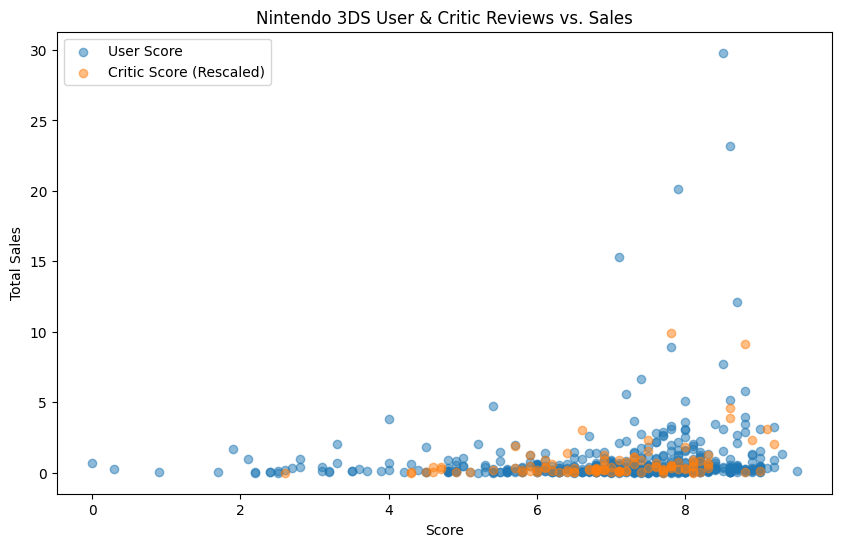

                       critic_score_rescaled  user_score  total_sales
critic_score_rescaled               1.000000    0.722762     0.320803
user_score                          0.722762    1.000000     0.197583
total_sales                         0.320803    0.197583     1.000000


In [22]:
# Specify 3DS as the platform
platform_users = games_filtered[games_filtered['platform'] == '3DS'].copy()
platform_critics = games_critics[games_critics['platform'] == '3DS'].copy()

# Rescale critic scores so they can be comparable to user scores
platform_critics['critic_score_rescaled'] = platform_critics['critic_score'] / 10

plt.figure(figsize=(10, 6))

# Scatter plot for user_score
plt.scatter(platform_data['user_score'], platform_data['total_sales'], alpha=0.5, label='User Score')

# Scatter plot for rescaled critic_score
plt.scatter(platform_critics['critic_score_rescaled'], platform_critics['total_sales'], alpha=0.5, label='Critic Score (Rescaled)')

plt.title('Nintendo 3DS User & Critic Reviews vs. Sales')
plt.xlabel('Score')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

# Calculate the correlation between rescaled critic scores, user scores, and total sales
# Add 'critic_score_rescaled' to 'platform_users'
platform_users['critic_score_rescaled'] = platform_critics['critic_score_rescaled']

# # Calculate the correlation
correlation = platform_users[['critic_score_rescaled', 'user_score', 'total_sales']].corr()

print(correlation)

It appears as though there is no correlation between user or critic reviews and total sales for a game on the Nintendo 3DS platform. 

Looking at the three platforms, we found that there is no correlation between user and critic scores to the total sales of a game. 

#### Looking at Genres

In [23]:
# Group the data by genre and sum the total sales
genre_sales = games_filtered.groupby('genre')['total_sales']

# Calculate the sum, mean, meadian, and count
summary_df = genre_sales.agg(['sum', 'count', 'mean', 'median', 'std']).sort_values(by='sum', ascending=False)

# Display the total sales by genre
print(summary_df)


                 sum  count      mean  median       std
genre                                                  
Action        441.12   1031  0.427856   0.120  1.166504
Shooter       304.73    235  1.296723   0.440  2.251662
Role-Playing  192.80    370  0.521081   0.140  1.315937
Sports        181.07    268  0.675634   0.240  1.136378
Misc           85.04    192  0.442917   0.120  1.081047
Platform       61.00     85  0.717647   0.210  1.364413
Racing         53.50    115  0.465217   0.140  0.888664
Fighting       44.49    109  0.408165   0.130  0.910385
Simulation     35.12     80  0.439000   0.120  1.244500
Adventure      29.43    302  0.097450   0.030  0.208237
Strategy       13.34     71  0.187887   0.080  0.271976
Puzzle          4.89     28  0.174643   0.045  0.305438


Action, shooter, role-playing, and sports games have the highest sales compared to other genres. The number of action games released is signigifcantly higher than other genres. The second highest in sales, shooter, happens to actually sell more per game on average. It looks like the games that are the most immersive or requires the player to do more physically (action and shooter, for example, may require more movement and quick hand-eye coordination and dexterity), while strategy and puzzle games which require more thought and reasoning before each move have the lowest sales. They also average pretty low in sales per game released.

#### Platforms by Sales in each region

In [24]:
# Top five platforms for each region
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    top_platforms = games_filtered.groupby('platform')[region].sum().sort_values(ascending=False).head(5)
    print(f"Top 5 platforms in {region}:\n{top_platforms}\n")

Top 5 platforms in na_sales:
platform
X360    140.05
PS4     108.74
PS3     103.38
XOne     93.12
3DS      55.31
Name: na_sales, dtype: float64

Top 5 platforms in eu_sales:
platform
PS4     141.09
PS3     106.86
X360     74.52
XOne     51.59
3DS      42.64
Name: eu_sales, dtype: float64

Top 5 platforms in jp_sales:
platform
3DS     87.79
PS3     35.29
PSV     21.04
PS4     15.96
WiiU    13.01
Name: jp_sales, dtype: float64



In North America, people prefer the Xbox, which is an American product. In Europe, people bought games for the PlayStation 3 and 4 more than they bought for the Xbox 360 and Xbox One. In Japan, it seems like Nintendo 3DS is their choice.

In [25]:
# Top five genres for each region
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    top_genres = games_filtered.groupby('genre')[region].sum().sort_values(ascending=False).head(5)
    print(f"Top 5 genres in {region}:\n{top_genres}\n")

Top 5 genres in na_sales:
genre
Action          177.84
Shooter         144.77
Sports           81.53
Role-Playing     64.00
Misc             38.19
Name: na_sales, dtype: float64

Top 5 genres in eu_sales:
genre
Action          159.34
Shooter         113.47
Sports           69.09
Role-Playing     48.53
Racing           27.29
Name: eu_sales, dtype: float64

Top 5 genres in jp_sales:
genre
Role-Playing    65.44
Action          52.80
Misc            12.86
Simulation      10.41
Fighting         9.44
Name: jp_sales, dtype: float64



Action is the most popular genre amongst all the regions. Shooters are the second most popular for North America and Europe, but not Japan, which favor Role-Playing games over shooter. Sports isn't even on the top five for Japan, while it's the third most popular genre in North America and Europe.

In [26]:
# ESRB ratings and sales in each region
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    esrb_sales = games_filtered.groupby('rating')[region].sum().sort_values(ascending=False)
    print(f"ESRB ratings and sales in {region}:\n{esrb_sales}\n")

ESRB ratings and sales in na_sales:
rating
M            231.57
E            114.37
Not Rated    103.31
E10+          75.70
T             66.02
Name: na_sales, dtype: float64

ESRB ratings and sales in eu_sales:
rating
M            193.96
E            113.03
Not Rated     91.50
E10+          55.37
T             52.96
Name: eu_sales, dtype: float64

ESRB ratings and sales in jp_sales:
rating
Not Rated    108.84
E             28.33
T             26.02
M             21.20
E10+           8.19
Name: jp_sales, dtype: float64



It seems the more mature the rating is, the higher the sales of the game in North America and Europe. In Japan, however, if the rating is "Everyone" then it has a higher sales. It could be because of culture.

## Testing Hypotheses
- Null hypothesis (H0): The average user ratings of the Xbox One and PC platforms are the same.
- Alternative hypothesis (H1): The average user ratings of the Xbox One and PC platforms are not the same.

In [27]:
# Filter the data for Xbox One and PC platforms
xbox_one_ratings = games_filtered[games_filtered['platform'] == 'XOne']['user_score'].dropna()
pc_ratings = games_filtered[games_filtered['platform'] == 'PC']['user_score'].dropna()

# Perform t-test
result = stats.ttest_ind(xbox_one_ratings, pc_ratings)

# Print the p-value
print('p-value:', result.pvalue)

p-value: 0.5535080500643661


We can set the alpha threshold value (significance level) to 0.05.

Since the p-value is greater than 0.05, we do not reject the null hypothesis and conclude that there is no significant difference between the Xbox One and PC user ratings. 

- Null hypothesis (H0): The average user ratings for the Action and Sports genres are the same.
- Alternative hypothesis (H1): The average user ratings for the Action and Sports genres are different.

In [28]:
# Filter the data for Action and Sports genres
action_ratings = games_filtered[games_filtered['genre'] == 'Action']['user_score'].dropna()
sports_ratings = games_filtered[games_filtered['genre'] == 'Sports']['user_score'].dropna()

# Perform t-test
result = stats.ttest_ind(action_ratings, sports_ratings)

# Print the p-value
print('p-value:', result.pvalue)

p-value: 3.716308946093486e-26


We can set the alpha threshold value (significance level) to 0.05.

Since the p-value is less than 0.05, we reject the null hypothesis.

## Conclusion

Looking at the data between 2012 and 2016 where it is one year before the new consoles came out, it still took about a year before the sales flipped from the previous generation to the new generation of platforms. There are no significant correlation between user or critic scores with the sales of games. Games that require quick hand-eye coordination are more popular than those that require thinking before doing. North American sales and European sales tend to be similar, but different from Japan sales when it comes to genre (except for Action games) and platform. The average user ratings between Xbox One and PC are the same, while the average user ratings between action and sports games are different.

Looking at the data, we can expect the following:

North America and Europe:
- The PS4 and Xbox One are expected to be the leading platforms in these regions. Perhaps it's the advanced hardware that are capable of handling Action and Shooter games that are popular in these regions.
- Action games are the most popular genre as far as total sales. Looking at the average sales per game, Shooters are the most profitable. This may suggest that games requiring quick hand-eye coordination are favored in North America and Europe.
- Games with an 'M' (Mature) rating sell the most in North America and Europe, likely due to the popularity of Action and Shooter games which often contain mature content.

Japan:
- The 3DS is the most popular platform followed by the PS3 and PS4. The popularity of handheld gaming in Japan likely contributes to the success of the 3DS.
- Action games are the most popular in Japan, followed by Role-Playing games. This may suggest that games offering immersive storytelling and character development are favored in Japan.
- Japan, games without an ESRB rating sell the most, followed by games with an 'E' (Everyone), then 'T' (Teen) rating. This may be because Japan has their own rating organization.


